In [1]:
import sys
import os
import json
import tensorflow as tf
import tqdm
from models.model import *
from ltv_utils import *
from losses.custom_loss import *
pd.set_option('display.float_format', '{:.4f}'.format)  # 保留10位小数，可调整
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)



def parse_function(serialized_example):
    feature_description = {
        'deviceid': tf.io.FixedLenFeature([], tf.string),
        'install_date': tf.io.FixedLenFeature([], tf.string),
        'dim_os_name1': tf.io.FixedLenFeature([], tf.string),
        'creative_classify1': tf.io.FixedLenFeature([], tf.string),
        'total_pay_amount1':  tf.io.FixedLenFeature([], tf.float32),
         'channel1': tf.io.FixedLenFeature([], tf.string),
        'b2_sale_amt_bias':  tf.io.FixedLenFeature([], tf.int64),
         'b2_sale_amt_7d': tf.io.FixedLenFeature([], tf.int64),
         'install_time': tf.io.FixedLenFeature([], tf.string),
        'install_order_diff':  tf.io.FixedLenFeature([], tf.int64),
        'all_install_order_7d_diff':  tf.io.FixedLenFeature([], tf.int64),
        'is_a1x_a33':  tf.io.FixedLenFeature([], tf.int64),
        'platform_label':  tf.io.FixedLenFeature([], tf.string),
        'user_dense_price_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_price_features'])], tf.float32),
        'user_dense_duration_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_duration_features'])], tf.float32),
        'user_dense_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_features'])], tf.float32),
        'user_sparse_features': tf.io.FixedLenFeature([len(group_2_features['user_sparse_features'])], tf.float32)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    return example


# load tf records
group_2_features = read_feature_json_config('features/feature_list.json')

train_file_name = 'data/loca_test_tf.tfrecords'
valid_file_name = 'data/loca_test_tf.tfrecords'

train_dataset, valid_dataset, _ = get_trian_valid_test_dateset(parse_function, 10240, train_file_name, valid_file_name)



user_dense_price_features = group_2_features['user_dense_price_features']
user_dense_duration_features = group_2_features['user_dense_duration_features']
user_dense_features = group_2_features['user_dense_features']
user_sparse_features = group_2_features['user_sparse_features']


In [2]:
MODEL_HOUR = 0 
def create_tf_dataset(dataset):
    sample_batch = next(iter(dataset))
    sample_data = {k: v for k, v in sample_batch.items() if k not in ['b2_sale_amt_7d', 'total_pay_amount1']}

    
    def generator():
        for batch in dataset:
            hour = tf.cast(tf.gather(batch['user_sparse_features'],  indices=0, axis = 1) - 1, tf.int64)    # shape: (batch_size,)
            b2_7d = tf.cast(tf.reshape(batch.pop('b2_sale_amt_7d'), (-1, 1)), tf.float32)
            # 将 b2_7d 中小于 0 的值替换为 0
            b2_7d = tf.maximum(b2_7d, 0.0)
            
            total_amt_1h = tf.reshape(batch.pop('total_pay_amount1'), (-1, 1))

            # 只保留 hour 为 MODEL_HOUR 的记录
            # hour_mask = tf.equal(hour, MODEL_HOUR)  # shape: (batch_size,)
            # hour_mask = tf.reshape(hour_mask, (-1, 1))  # 广播成 (batch_size, 1)
            
            # # # 使用 hour_mask 筛选 batch 中的 对应小时窗口 
            # selected_indices = tf.where(hour_mask)[:, 0]  # 获取 hour == 1 的样本索引
            # batch = {k: tf.gather(v, selected_indices, axis=0) for k, v in batch.items()}  # 筛选 batch 中的样本
            # b2_7d = tf.gather(b2_7d, selected_indices, axis=0)  # 保留 hour == 1 对应的标签
            # total_amt_1h = tf.gather(total_amt_1h, selected_indices, axis=0)  # 保留 hour == 1 对应的标签

            # # 给某个小时 增加 真实值，测一下期望拟合
            # hour_mask = tf.equal(hour, 4)  # shape: (batch_size,)
            # hour_mask = tf.reshape(hour_mask, (-1, 1))  # 广播成 (batch_size, 1)
            # # ✅ 对应位置加 10000
            # b2_7d = tf.where(hour_mask, b2_7d + 10000.0, b2_7d)

            
    
            # 将保留的样本和标签一起返回
            y_true_packed = tf.concat([b2_7d, total_amt_1h], axis=1)

            # y_true_packed = b2_7d
            yield batch, y_true_packed
        

    # 正确写法：output_signature 中保留每个字段的真实 shape
    output_signature = (
        {
            name: tf.TensorSpec(shape=(None,) + v.shape[1:], dtype=v.dtype)
            for name, v in sample_data.items()
        },
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)



In [3]:

emb_features = [
'creative_classify','dim_device_manufacture', 'car_add_type_most','show_order_is_2arrival_latest', 'selecttirecount_most', 'show_order_is_2arrival_most','selecttirecount_latest',
 'new_sitename','advsite','car_add_type_latest','platform_level', 'tire_list_click_avg_index','tire_list_click_most_pid_level','tire_order_page_most_pid_level',
]


model = MULTI_HEAD_LTV_MODEL(5, [200], [200,128], 'user_dense_features', 'user_dense_price_features', 'user_dense_duration_features',
                            'user_sparse_features',user_sparse_features, emb_features)


sample = next(iter(train_dataset))
input_shape = {k: v.shape for k, v in sample.items()}


2025-06-27 15:25:31.542715: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [4]:
# 自己实现的双口loss
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 监控验证集上的 loss
    patience=3,          # 如果连续 3 轮没有改善，就停止训练
    restore_best_weights=True  # 训练结束后恢复到最优模型
)

loss_fn = UnifiedLTVLoss('delta')
model.compile(loss=loss_fn, 
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),  
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
             )


In [9]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1, profile_batch=0)
model.fit(
    create_tf_dataset(train_dataset),
    epochs=1,
    validation_data = create_tf_dataset(valid_dataset),
    callbacks= [early_stopping, tensorboard_callback]
) 

18/18 [==============================] - 6s 300ms/step - rmse: 247.2174 - val_loss: 45628.3320 - val_rmse: 245.9364


In [6]:
import tensorflow as tf
# 确保模型已构建，可以先跑一条样本
sample = next(iter(train_dataset))
model(sample)  # 让模型初始化权重和结构

# 1. 启动 profiler
tf.profiler.experimental.start('logs')

# 2. 跑一次模型（比如跑一个 batch）
_ = model(sample)  # 你之前已经拿过 sample = next(iter(dataset))

# 3. 停止 profiler
tf.profiler.experimental.stop()



2025-06-27 15:25:48.659176: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2025-06-27 15:25:48.659401: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2025-06-27 15:25:48.747408: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2025-06-27 15:25:48.752546: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2025-06-27 15:25:48.756625: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/2025_06_27_15_25_48

2025-06-27 15:25:48.758962: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/plugins/profile/2025_06_27_15_25_48/CK-L220022-2.local.trace.json.gz
2025-06-27 15:25:48.760930: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/2025_06_27_15_25_48

2025-06-27 15:25:48.761868: I tensorflow/c

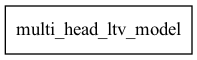

In [7]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [10]:
from graphviz import Digraph

dot = Digraph(comment='Multi-head LTV Model')

# 输入节点
dot.node('A', 'Dense Features')
dot.node('B', 'Sparse Features')

# 特征处理
dot.node('C', 'Dense_Process_LOG_Layer')
dot.node('D', 'Sparse_Process_Layer')

# 拼接
dot.node('E', 'Concatenate Dense + Sparse')

# 共享底层
dot.node('F', 'Sharebottom DNN')

# 多头分支
for i in range(3):  # 假设num_heads=3
    dot.node(f'G{i}', f'Head_DNN_{i+1}')

# 选择头
dot.node('H', 'Select Head Output by hour_idx')

# 输出
dot.node('I', 'Final Output')

# 连接
dot.edges(['AC', 'BD', 'CE', 'DE', 'EF'])
for i in range(3):
    dot.edge('F', f'G{i}')
    dot.edge(f'G{i}', 'H')

dot.edge('H', 'I')

# 保存与渲染
dot.render('multi_head_ltv_model', format='png', view=True)

ModuleNotFoundError: No module named 'graphviz'